In [1]:
import pandas as pd
import matplotlib.pyplot as plt

cpg_sample_df = pd.read_csv('cpg_sample_df.csv')
meth_df = pd.read_csv('../../output_data/DNAMethylation.csv')
cols = list(cpg_sample_df['Sample'].values)

meth_df = meth_df.replace(0, 0.001)
meth_df = meth_df.replace(1.0, 0.999)


In [2]:
import numpy as np
mean_meth = np.nanmean(meth_df[cols].values, axis=1)
meth_df = meth_df[mean_meth > 0.05]
mean_meth = np.nanmean(meth_df[cols].values, axis=1)


/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_72664/889742584.py:2: RuntimeWarning: Mean of empty slice
  mean_meth = np.nanmean(meth_df[cols].values, axis=1)


TypeError: 'numpy.float64' object is not iterable

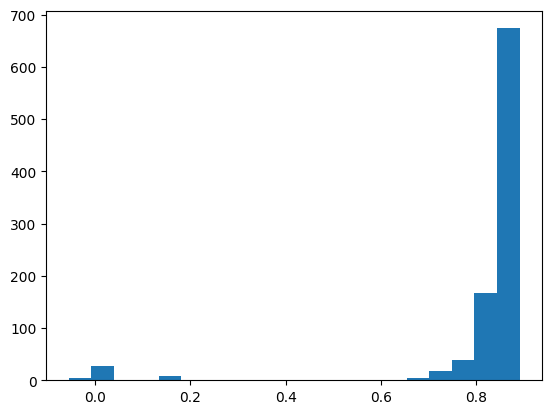

In [3]:
meth_df = meth_df[mean_meth < 0.95]
corr = meth_df[cols].corr()
# Print out the minimum correlation:
mean_cor = np.nanmean(corr, axis=1)
corr['mean_corr'] = mean_cor
corr.sort_values(by=['mean_corr'])
# Plot out the mean correlation values so we can choose a good filter.
plt.hist(mean_cor, bins=20)
plt.title(f'min corr: {min(np.min(corr))}')


In [11]:

# Filter the shitty patients
corr_sorted = corr.sort_values(by=['mean_corr'])
corr_sorted = corr_sorted[corr_sorted['mean_corr'] < 0.7]

cols_to_omit = [c for c in corr_sorted.index]
print('\n'.join(cols_to_omit))
cols_to_keep = [c for c in meth_df.columns if c not in cols_to_omit]
cpg_filtered = meth_df[cols_to_keep]

# Filter sample df to only include those samples
sample_df = cpg_sample_df[cpg_sample_df['Sample'].isin(cols_to_keep)]

C3N.01719_Tumor_CpG_PancreaticDuctalAdenocarcinoma_d97c51cd.deac.42a6.9fdf.3941fe370ecc
C3N.00388_Tumor_CpG_UterineCorpusEndometrialCarcinoma_7cd78ad0.fd44.4bf1.8700.e4cf732fa1b6
C3N.03426_Tumor_CpG_PancreaticDuctalAdenocarcinoma_d09f9fcc.2b8b.436a.8ffd.9d7455c9b1ab
C3N.02971_Tumor_CpG_PancreaticDuctalAdenocarcinoma_977dd7b9.cfb7.42f2.b554.e43c23b9f3e9
C3N.04283_Tumor_CpG_PancreaticDuctalAdenocarcinoma_de177c77.a468.4813.bea8.d9dcfc71756e
C3N.03039_Tumor_CpG_PancreaticDuctalAdenocarcinoma_c99d1277.232f.429b.a454.60ad604d4e34
C3L.00913_Normal_CpG_LungAdenocarcinoma_5ff19da1.fba3.413f.9313.98b16729f3f0
C3N.03439_Tumor_CpG_PancreaticDuctalAdenocarcinoma_8b590f21.dca8.40f4.adc8.790892f151ee
C3N.03884_Tumor_CpG_PancreaticDuctalAdenocarcinoma_0965e7fc.4993.46b0.bbba.7fb1a20dd3af
C3N.02579_Tumor_CpG_PancreaticDuctalAdenocarcinoma_1828851d.743b.4169.bcc9.e1e1ffc3061e
C3N.00709_Tumor_CpG_PancreaticDuctalAdenocarcinoma_40b2e99d.d4c8.4abc.82b1.6d7c76f04a3f
C3L.01889_Tumor_CpG_LungAdenocarcinoma_d

# Now we want to check each cancer has a separation between tumour and normal and all cancers also have a decent separation

In [12]:
# Drop CpGs with > 50% missing values
cpg_filtered = cpg_filtered[cpg_filtered.isnull().sum(axis=1) < len(meth_df.values[0])/2]


In [16]:

# Fill NAs with 0's
df = cpg_filtered.fillna(0.001)

cols = list(sample_df['Sample'].values)
vals = df[cols].values.T
# If there is a missing CpG replace it with the mean value for that CpG


In [13]:
import pandas as pd
from sciviso import *
from sciutil import SciUtil
import seaborn as sns
# Have a look at clustering each of these
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_values = pca.fit_transform(vals)
var_ratio = pca.fit(vals).explained_variance_ratio_
plt.rcParams['figure.figsize'] = [4, 4]
vis_df = pd.DataFrame()
vis_df['PC_1'] = pca_values[:, 0]
vis_df['PC_2'] = pca_values[:, 1]
vis_df['Stage'] = sample_df['TumorStage_x'].values
vis_df['Disease'] = sample_df['Disease'].values
vis_df['CondID'] = sample_df['CondID'].values


AttributeError: module 'seaborn' has no attribute 'scatter'

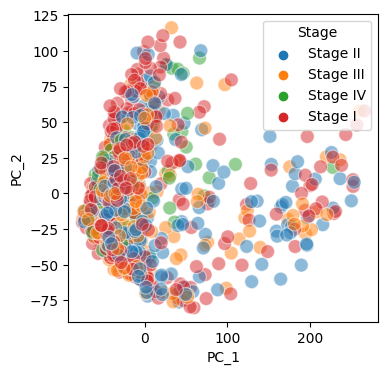

In [14]:

sns.scatterplot(vis_df, x='PC_1', y='PC_2', hue='Stage', s=100, alpha=0.5)
plt.show()

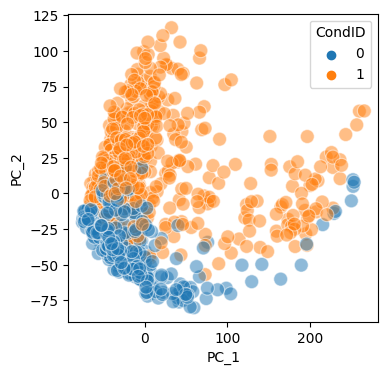

In [15]:

sns.scatterplot(vis_df, x='PC_1', y='PC_2', hue='CondID', s=100, alpha=0.5)
plt.show()

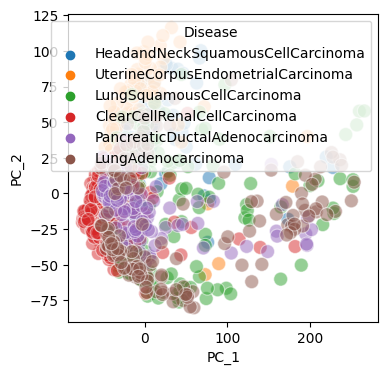

In [19]:

sns.scatterplot(vis_df, x='PC_1', y='PC_2', hue='Disease', s=100, alpha=0.5)
plt.show()

In [17]:
df.to_csv('../../output_data/filtered_CpG.csv', index=False)

In [18]:
sample_df.to_csv('../../output_data/filtered_samples_CpG.csv', index=False)

# Differential analysis

https://bioconductor.org/packages/devel/bioc/vignettes/missMethyl/inst/doc/missMethyl.html#removing-unwanted-variation-when-testing-for-differential-methylation

```
If the number of samples in your experiment is greater than the number of Illumina negative controls on the array platform used - 613 for 450k, 411 for EPIC - stage 1 of RUVm will not work. In such cases, we recommend performing a standard limma analysis in stage 1.
```